# Imports

In [2]:
import json
import os
import pandas as pd
import re

In [3]:
import spacy
from spacy import displacy
from spacy.tokens import Span

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset, load_from_disk

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
%run PII_Util.py

# Load Data

In [7]:
path_train = './in/train.json'
path_test = './in/test.json'

In [8]:
train_json = json.load(open(path_train))
df_unsplitted = pd.json_normalize(train_json)

test_json = json.load(open(path_test))
df_test = pd.json_normalize(test_json)

In [9]:
df_unsplitted.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [10]:
def label_count_columns(df, possible_labels):
    # Initialize a dictionary to store the count of each label
    label_counts = {label: [] for label in possible_labels}
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        # Use Counter to count the occurrence of each label in the sequence
        row_label_counts = Counter(row['labels'])
        
        # Append the counts to the label_counts dictionary
        for label in possible_labels:
            label_counts[label].append(row_label_counts[label])
    
    # Create a new DataFrame from the label_counts dictionary
    label_counts_df = pd.DataFrame(label_counts)
    
    return label_counts_df

In [11]:
%%time
df_dist = label_count_columns(df_unsplitted, classes)

CPU times: total: 781 ms
Wall time: 782 ms


In [12]:
df_dist

,O,B-EMAIL,B-ID_NUM,B-NAME_STUDENT,B-PHONE_NUM,B-STREET_ADDRESS,B-URL_PERSONAL,B-USERNAME,I-ID_NUM,I-NAME_STUDENT,I-PHONE_NUM,I-STREET_ADDRESS,I-URL_PERSONAL
0,747,0,0,3,0,0,0,0,0,3,0,0,0
1,559,0,0,2,0,0,0,0,0,2,0,0,0
2,727,0,0,1,0,0,0,0,0,1,0,0,0
3,1069,0,0,1,0,0,0,0,0,1,0,0,0
4,1925,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,601,0,0,0,0,0,0,0,0,0,0,0,0
6803,433,0,0,0,0,0,0,0,0,0,0,0,0
6804,633,0,0,0,0,0,0,0,0,0,0,0,0
6805,679,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def perform_dbscan_clustering(label_counts_df, eps=0.5, min_samples=5):
    # Standardize the feature values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(label_counts_df)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_features)
    
    # Add cluster labels to the DataFrame
    label_counts_df['cluster'] = dbscan.labels_
    
    return label_counts_df

In [14]:
df_dist = perform_dbscan_clustering(df_dist, eps=0.5, min_samples=5)

In [15]:
df_dist.cluster.value_counts()

cluster
 9    5856
 2     579
-1     158
 1      88
 3      50
 0      26
 4      21
 5      11
 7       7
 8       6
 6       5
Name: count, dtype: int64

# Split to Train and Validation

In [16]:
from sklearn.model_selection import train_test_split

## normal split

In [17]:
df_train, df_valid = train_test_split(df_unsplitted, test_size=0.12, random_state=42)

In [18]:
df_train

,document,full_text,tokens,trailing_whitespace,labels
84,2732,Example Reflection – Visualization\n\nChalleng...,"[Example, Reflection, –, Visualization, \n\n, ...","[True, True, True, False, False, False, False,...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,..."
1511,10656,Mind Mapping\n\nChallenge and Selection:\n\nTh...,"[Mind, Mapping, \n\n, Challenge, and, Selectio...","[True, False, False, True, True, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1426,10495,Reflection - Mind Mapping\n\nChallenge & Selec...,"[Reflection, -, Mind, Mapping, \n\n, Challenge...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3012,13878,Learning Launch\n\nChallenge\n\nAs an employee...,"[Learning, Launch, \n\n, Challenge, \n\n, As, ...","[True, False, False, False, False, True, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
425,7115,Design Thinking for Innovation (Jan – Feb 2018...,"[Design, Thinking, for, Innovation, (, Jan, –,...","[True, True, True, True, False, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...
3772,15720,Use of visualization technique to explore var...,"[Use, of, visualization, technique, to, explor...","[True, True, True, True, True, True, False, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5191,19181,Challenges\n\nWe are a business which offers t...,"[Challenges, \n\n, We, are, a, business, which...","[False, False, True, True, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5226,19258,Challenge & Selection My company provides aro...,"[Challenge, &, Selection, , My, company, prov...","[True, True, True, False, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5390,19584,"Visualization Tool\n\nChallenge\n\nMy task, as...","[Visualization, Tool, \n\n, Challenge, \n\n, M...","[True, False, False, False, False, True, False...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### df_train stats

In [19]:
%%time

df_cur = df_train
col_tokens = 'tokens'
col_labels = 'labels'
col_id = 'document'

df_cur['token_index'] = df_cur[col_tokens].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_cur.set_index(col_id)[[col_tokens,col_labels, 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 578 ms
Wall time: 642 ms


,id,token,labels,token_index
0,2732,Example,O,0
1,2732,Reflection,O,1
2,2732,–,O,2
3,2732,Visualization,O,3
4,2732,\n\n,O,4
...,...,...,...,...
4383939,9354,group,O,980
4383940,9354,of,O,981
4383941,9354,officers,O,982
4383942,9354,.,O,983


In [20]:
%%time
ser_value_counts = df_tokens.labels.value_counts()
ser_value_counts

CPU times: total: 219 ms
Wall time: 240 ms


labels
O                   4381551
B-NAME_STUDENT         1206
I-NAME_STUDENT          950
B-URL_PERSONAL           89
B-ID_NUM                 70
B-EMAIL                  39
I-PHONE_NUM              15
I-STREET_ADDRESS         10
B-USERNAME                6
B-PHONE_NUM               5
I-URL_PERSONAL            1
I-ID_NUM                  1
B-STREET_ADDRESS          1
Name: count, dtype: int64

<Axes: ylabel='labels'>

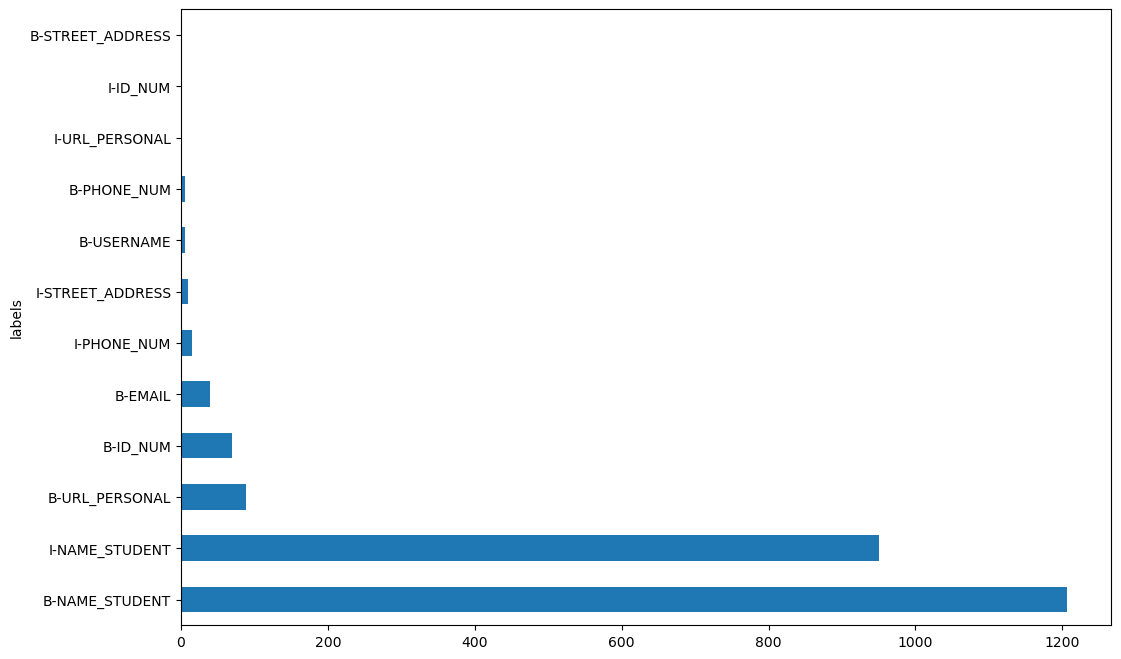

In [21]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

### df_valid stats

In [22]:
df_valid

,document,full_text,tokens,trailing_whitespace,labels
4624,17809,Assignment: Mindmapping\n\nChallenge\n\nThe ch...,"[Assignment, :, Mindmapping, \n\n, Challenge, ...","[False, True, False, False, False, False, True...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1740,11144,Reflection – Learning Launch\n\nPaola Garcia\n...,"[Reflection, –, Learning, Launch, \n\n, Paola,...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
3948,16158,Visualisation\n\nChallenge & Selection\n\nThe ...,"[Visualisation, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1158,9980,Reflection: Storytelling\n\nChallenge I am ...,"[Reflection, :, Storytelling, \n\n, Challenge,...","[False, True, False, False, True, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4567,17676,Project Title: Learning Modalities in the Pand...,"[Project, Title, :, Learning, Modalities, in, ...","[True, False, True, True, True, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...
5412,19631,Reflexion - Learning Launch\n\nChallenge\n\nI ...,"[Reflexion, -, Learning, Launch, \n\n, Challen...","[True, True, True, False, False, False, False,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4957,18619,Challenge and Selection:\n\nVisual Thinking is...,"[Challenge, and, Selection, :, \n\n, Visual, T...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1535,10720,"I’m Hady Wong, I From Haiti, born and raised i...","[I, ’m, Hady, Wong, ,, I, From, Haiti, ,, born...","[False, True, True, False, True, True, True, F...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
1407,10458,Story Telling\n\nChallenge & Selection Story ...,"[Story, Telling, \n\n, Challenge, &, Selection...","[True, False, False, True, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [23]:
%%time

df_cur = df_valid
col_tokens = 'tokens'
col_labels = 'labels'
col_id = 'document'

df_cur['token_index'] = df_cur[col_tokens].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_cur.set_index(col_id)[[col_tokens,col_labels, 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 109 ms
Wall time: 83 ms


,id,token,labels,token_index
0,17809,Assignment,O,0
1,17809,:,O,1
2,17809,Mindmapping,O,2
3,17809,\n\n,O,3
4,17809,Challenge,O,4
...,...,...,...,...
608584,17140,methodology,O,836
608585,17140,of,O,837
608586,17140,storytelling,O,838
608587,17140,.,O,839


In [24]:
%%time
ser_value_counts = df_tokens.labels.value_counts()
ser_value_counts


CPU times: total: 31.2 ms
Wall time: 30 ms


labels
O                   608243
B-NAME_STUDENT         159
I-NAME_STUDENT         146
B-URL_PERSONAL          21
I-STREET_ADDRESS        10
B-ID_NUM                 8
B-STREET_ADDRESS         1
B-PHONE_NUM              1
Name: count, dtype: int64

<Axes: ylabel='labels'>

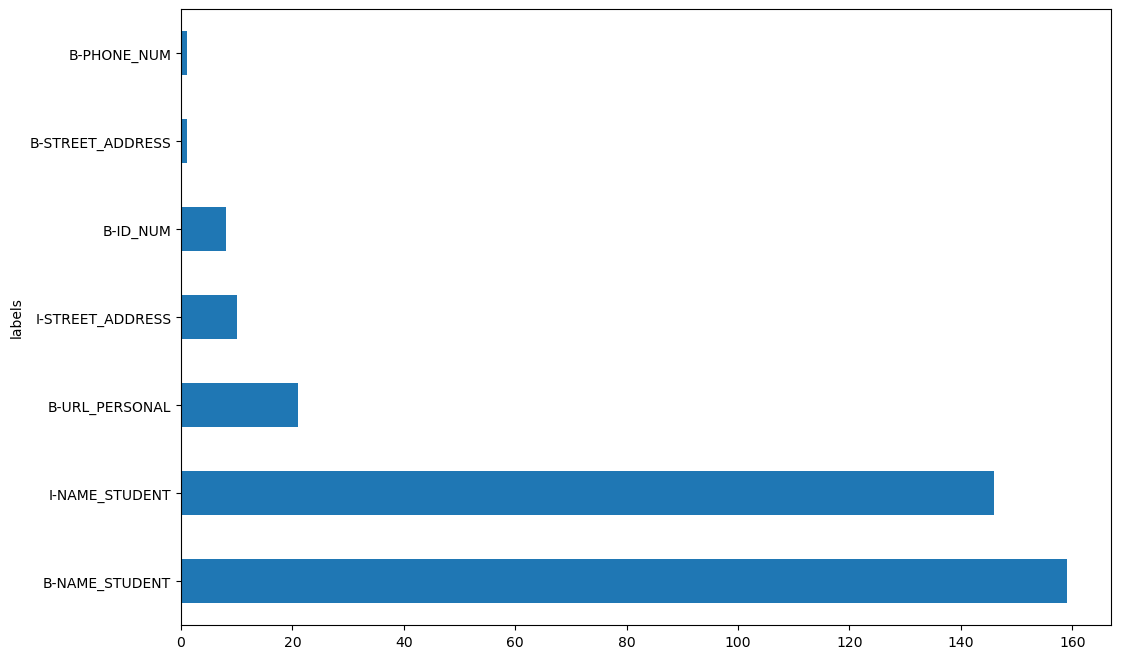

In [25]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

## with stratification

In [26]:
df_train, df_valid = train_test_split(df_unsplitted, test_size=0.12, random_state=42, stratify=df_dist['cluster'])

### df_train stats

In [27]:
df_train

,document,full_text,tokens,trailing_whitespace,labels
2383,12465,Challenge & Selection\n\nI work as consultant ...,"[Challenge, &, Selection, \n\n, I, work, as, c...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4220,16834,Visualization as a tool\n\nChallenge: Fashion ...,"[Visualization, as, a, tool, \n\n, Challenge, ...","[True, True, True, False, False, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2331,12350,"Challenge On a January afternoon, I was vaca...","[Challenge, , On, a, January, afternoon, ,, ...","[True, False, True, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6499,22029,Reflection – Mind Mapping\n\nChallenge & Selec...,"[Reflection, –, Mind, Mapping, \n\n, Challenge...","[True, True, True, False, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1677,11009,Reflection – Learning Launch\n\nChallenge & Se...,"[Reflection, –, Learning, Launch, \n\n, Challe...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...
510,8192,Studio X\n\nRoberto Hasan Papers\n\nEmpathy.Cr...,"[Studio, X, \n\n, Roberto, Hasan, Papers, \n\n...","[True, False, False, True, True, False, False,...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
2350,12404,Reflection – Storytelling\n\nChallenge\n\nI am...,"[Reflection, –, Storytelling, \n\n, Challenge,...","[True, True, False, False, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2343,12381,"Name: Sandro Santander\n\nDate: October 14th, ...","[Name, :, Sandro, Santander, \n\n, Date, :, Oc...","[False, True, True, False, False, False, True,...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
5889,20716,Medical System Improvement – Visualization Too...,"[Medical, System, Improvement, –, Visualizatio...","[True, True, True, True, True, False, False, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [28]:
%%time

df_cur = df_train
col_tokens = 'tokens'
col_labels = 'labels'
col_id = 'document'

df_cur['token_index'] = df_cur[col_tokens].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_cur.set_index(col_id)[[col_tokens,col_labels, 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 609 ms
Wall time: 610 ms


,id,token,labels,token_index
0,12465,Challenge,O,0
1,12465,&,O,1
2,12465,Selection,O,2
3,12465,\n\n,O,3
4,12465,I,O,4
...,...,...,...,...
4402049,5662,Africa,O,831
4402050,5662,.,O,832
4402051,5662,\n\n,O,833
4402052,5662,http://chang.com/tagspost.asp,B-URL_PERSONAL,834


In [29]:
%%time
ser_value_counts = df_tokens.labels.value_counts()
ser_value_counts


CPU times: total: 219 ms
Wall time: 213 ms


labels
O                   4399620
B-NAME_STUDENT         1226
I-NAME_STUDENT          972
B-URL_PERSONAL           93
B-ID_NUM                 75
B-EMAIL                  34
I-PHONE_NUM              12
I-STREET_ADDRESS         10
B-USERNAME                5
B-PHONE_NUM               4
B-STREET_ADDRESS          1
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

<Axes: ylabel='labels'>

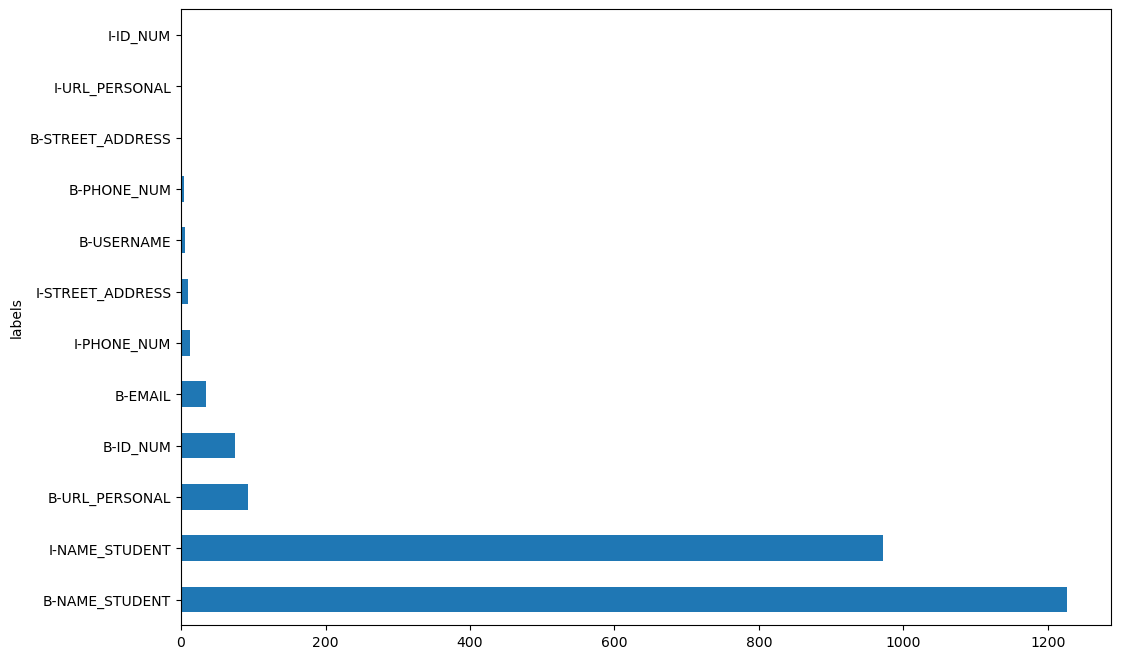

In [30]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

### df_valid stats

In [31]:
df_valid

,document,full_text,tokens,trailing_whitespace,labels
2973,13770,Coursera Assignment for Design Thinking Submis...,"[Coursera, Assignment, for, Design, Thinking, ...","[True, True, True, True, True, False, False, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
954,9548,Elements:\n\n1. Challenge: Describe your chall...,"[Elements, :, \n\n, 1, ., Challenge, :, Descri...","[False, False, False, False, True, False, True...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4841,18333,Example Reflection – Learning Launch\n\nChalle...,"[Example, Reflection, –, Learning, Launch, \n\...","[True, True, True, True, False, False, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4723,18042,DESIGN THINKING WITH METHOD : LEARNING LAUNCH\...,"[DESIGN, THINKING, WITH, METHOD, :, LEARNING, ...","[True, True, True, True, True, True, False, Fa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6620,22285,Challenge & Selection\n\nTo achieve new result...,"[Challenge, &, Selection, \n\n, To, achieve, n...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...
5403,19615,"Challenge\n\nMy marketing teacher, he assigned...","[Challenge, \n\n, My, marketing, teacher, ,, h...","[False, False, True, True, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5919,20806,Reflection - Mindmapping\n\nChallenge\n\nAs a ...,"[Reflection, -, Mindmapping, \n\n, Challenge, ...","[True, True, False, False, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6563,22167,Reflection – Storytelling\n\nChallenge and Sel...,"[Reflection, –, Storytelling, \n\n, Challenge,...","[True, True, False, False, True, True, False, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4158,16668,MAINTENANCE & REPAIR MOBILE APP\n\nLearning La...,"[MAINTENANCE, &, REPAIR, MOBILE, APP, \n\n, Le...","[True, True, True, True, False, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [32]:
%%time

df_cur = df_valid
col_tokens = 'tokens'
col_labels = 'labels'
col_id = 'document'

df_cur['token_index'] = df_cur[col_tokens].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_cur.set_index(col_id)[[col_tokens,col_labels, 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 78.1 ms
Wall time: 75 ms


,id,token,labels,token_index
0,13770,Coursera,O,0
1,13770,Assignment,O,1
2,13770,for,O,2
3,13770,Design,O,3
4,13770,Thinking,O,4
...,...,...,...,...
590474,9049,this.(I,O,790
590475,9049,appreciate,O,791
590476,9049,that,O,792
590477,9049,),O,793


In [33]:
%%time
ser_value_counts = df_tokens.labels.value_counts()
ser_value_counts


CPU times: total: 31.2 ms
Wall time: 30 ms


labels
O                   590174
B-NAME_STUDENT         139
I-NAME_STUDENT         124
B-URL_PERSONAL          17
I-STREET_ADDRESS        10
B-EMAIL                  5
I-PHONE_NUM              3
B-ID_NUM                 3
B-PHONE_NUM              2
B-STREET_ADDRESS         1
B-USERNAME               1
Name: count, dtype: int64

<Axes: ylabel='labels'>

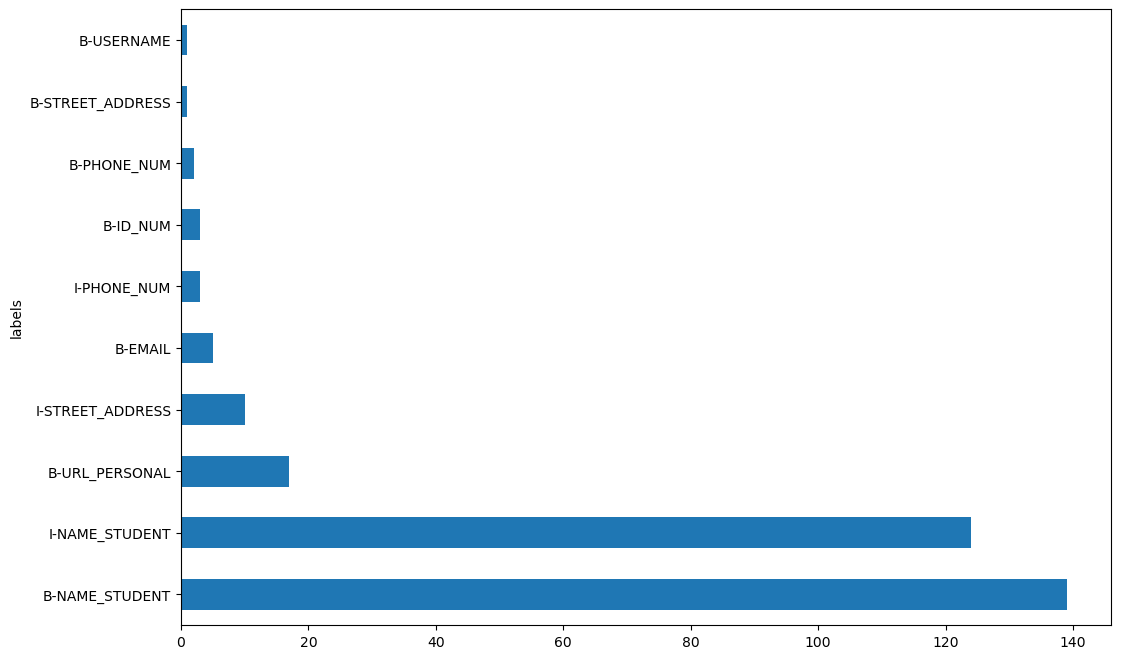

In [34]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

# Preprocessing

In [35]:
df_train = df_train.drop(columns =['token_index'])

In [36]:
df_train.head()

,document,full_text,tokens,trailing_whitespace,labels
2383,12465,Challenge & Selection\n\nI work as consultant ...,"[Challenge, &, Selection, \n\n, I, work, as, c...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4220,16834,Visualization as a tool\n\nChallenge: Fashion ...,"[Visualization, as, a, tool, \n\n, Challenge, ...","[True, True, True, False, False, False, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2331,12350,"Challenge On a January afternoon, I was vaca...","[Challenge, , On, a, January, afternoon, ,, ...","[True, False, True, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6499,22029,Reflection – Mind Mapping\n\nChallenge & Selec...,"[Reflection, –, Mind, Mapping, \n\n, Challenge...","[True, True, True, False, False, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1677,11009,Reflection – Learning Launch\n\nChallenge & Se...,"[Reflection, –, Learning, Launch, \n\n, Challe...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
from datasets import Dataset

In [93]:
Dataset

torch.utils.data.dataset.Dataset

In [96]:
ds_train = Dataset.from_pandas(df_train)
ds_valid = Dataset.from_pandas(df_valid)

In [105]:
%run PII_Util.py

In [217]:
%%time
model_adapter = Yanis_Adapter(threshold = 0.1, from_scratch=True, mode_bio='reorder')

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at Yanis/microsoft-deberta-v3-large_ner_conll2003-anonimization_TRY_1 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([18, 1024]) in the checkpoint and torch.Size([15, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([18]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: total: 12.5 s
Wall time: 9.2 s


In [40]:
classes2id

{'O': 0,
 'B-EMAIL': 1,
 'B-ID_NUM': 2,
 'B-NAME_STUDENT': 3,
 'B-PHONE_NUM': 4,
 'B-STREET_ADDRESS': 5,
 'B-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'I-ID_NUM': 8,
 'I-NAME_STUDENT': 9,
 'I-PHONE_NUM': 10,
 'I-STREET_ADDRESS': 11,
 'I-URL_PERSONAL': 12}

In [109]:
%%time
ds_prep_train = ds_train.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter, "col_words": "tokens", "col_labels": "labels", "mode_bio": model_adapter.mode_bio}, batched=False)

Map: 100%|█████████████████████████████████████████████████████████████████| 5990/5990 [00:59<00:00, 100.25 examples/s]

CPU times: total: 1min
Wall time: 1min 5s


In [108]:
%%time
# ds_prep_train = ds_train.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter}, batched=False)
ds_prep_valid = ds_valid.map(preprocess_from_words, fn_kwargs={"model_adapter": model_adapter, "col_words": "tokens", "col_labels": "labels", "mode_bio": model_adapter.mode_bio}, batched=False)

Map: 100%|████████████████████████████████████████████████████████████████████| 817/817 [00:08<00:00, 95.51 examples/s]

CPU times: total: 18.6 s
Wall time: 24.9 s


In [ ]:
ds_prep_valid[5]['document']

len(ds_prep_valid)

In [ ]:
for i in ds_prep_valid:
    print(i)
    break

In [ ]:
for i, sample in enumerate(ds_prep_valid):
    counter = Counter(sample['labels'])
    if len(counter) > 1:
        print(i)
        break

In [ ]:
len(counter)

# Trainer API

In [90]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from datasets import load_metric
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [94]:
from datasets import Dataset

In [114]:
model = model_adapter.model

In [111]:
data_collator = DataCollatorForTokenClassification(model_adapter.tokenizer)

In [149]:
temp_train = ds_prep_train.select(range(0, 2))
temp_valid = ds_prep_valid.select(range(0, 2))

In [148]:
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=1000,
    output_dir='./results', 
    optim="adafactor",
    per_device_eval_batch_size=1,        # batch size for evaluation
    eval_accumulation_steps = 1,
    
#     warmup_steps=500,                    # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,                   # strength of weight decay
    evaluation_strategy="steps",
    eval_steps=1000,                      # evaluate every 500 steps
    load_best_model_at_end=True,           # stop training if no improvement for 3 evaluations
    
)

trainer = Trainer(
    model=model,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                # training arguments, defined above
    train_dataset=temp_train,       # training dataset
    eval_dataset=temp_valid,          # evaluation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    data_collator=data_collator,

    
)

In [146]:
ds_prep_train.select(range(10, 20))

Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels', '__index_level_0__', 'input_ids', 'attention_mask', 'token_labels', 'words', 'word_labels', 'word_ids'],
    num_rows: 10
})

## Run


In [150]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

15375

In [117]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [123]:
del trainer

In [151]:
result = trainer.train()

Step,Training Loss,Validation Loss


In [155]:
pred_results = trainer.predict(temp_valid)

# Postprocessing

In [162]:
np_preds = pred_results.predictions

In [163]:
labels_padded = pad_lists(temp_valid['labels'], -100, np_preds.shape[1])

In [165]:
labels_padded

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ..., -100, -100, -100]])

In [ ]:
total_metrics, class_metrics, confusion_matrix = compute_micro_metrics(predictions = flat_label_ids, labels = flat_true_labels_id, num_classes = len(classes), pos_labels=classes_pos_id, beta=5)

In [167]:
import functools

In [218]:
# dataset = load_from_disk(path_dataset)
# np_preds = np.load(path_preds)

dataset=temp_valid
np_preds = np_preds
np_labels = pad_lists(dataset['labels'], -100, np_preds.shape[1])

threshold = model_adapter.threshold
compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=dataset, model_adapter=model_adapter, threshold=threshold)

eval_preds = (np_preds, np_labels, None)
dict_all_scores = compute_metrics(eval_preds)

token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')

df_all_metrics = pd.DataFrame(dict_all_scores)

col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
df_all_metrics = df_all_metrics.T

In [219]:
model_adapter.config.label2id

{'O': 0,
 'B-EMAIL': 1,
 'B-ID_NUM': 2,
 'B-NAME_STUDENT': 3,
 'B-PHONE_NUM': 4,
 'B-STREET_ADDRESS': 5,
 'B-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'I-ID_NUM': 8,
 'I-NAME_STUDENT': 9,
 'I-PHONE_NUM': 10,
 'I-STREET_ADDRESS': 11,
 'I-URL_PERSONAL': 12,
 'I-EMAIL': 13,
 'I-USERNAME': 14}

In [220]:
df_all_metrics

,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.0,0.000000,0.00000,0.0,1295.0,0.0
word_total_metrics,0.0,0.000000,0.00000,0.0,1246.0,0.0
token_O,0.0,0.000000,0.00000,0.0,0.0,1295.0
token_B-EMAIL,0.0,0.000000,0.00000,0.0,99.0,0.0
token_B-ID_NUM,0.0,0.000000,0.00000,0.0,29.0,0.0
token_B-NAME_STUDENT,0.0,0.000000,0.00000,0.0,244.0,0.0
token_B-PHONE_NUM,0.0,0.000000,0.00000,0.0,121.0,0.0
token_B-STREET_ADDRESS,0.0,0.000000,0.00000,0.0,299.0,0.0
token_B-URL_PERSONAL,0.0,0.000000,0.00000,0.0,2.0,0.0
token_B-USERNAME,0.0,0.000000,0.00000,0.0,1.0,0.0


# Results Stat

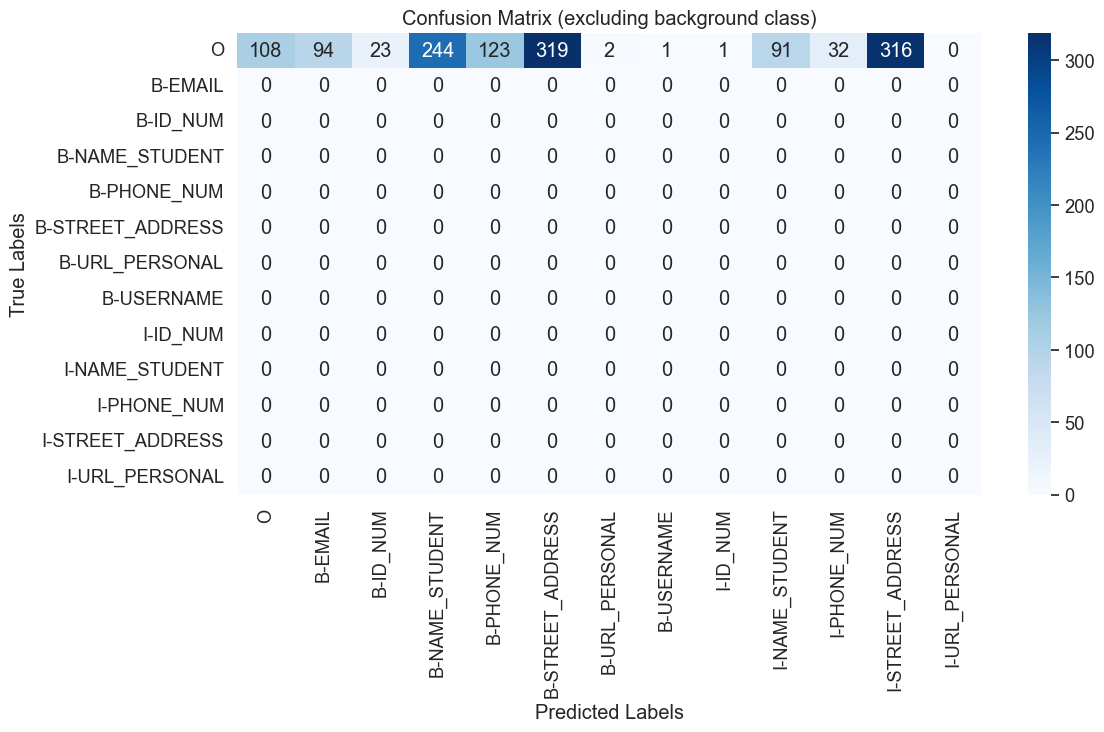

In [221]:
conf_matrix = word_confusion_matrix

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Results Manual

In [236]:
%%time
visualize_entry(1,temp_valid, np_preds, vis_mode='subwords')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 871 but corresponding boolean dimension is 424

In [110]:
cur_index = 0
cur_sample = temp_valid[cur_index]

cur_tokens = cur_sample['tokens']
cur_token_ids = np_label_ids[i_cur][:len(cur_tokens)]
cur_token_labels = [id2classes[label_id] for label_id in cur_token_ids]
cur_token_preds = 

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

In [ ]:
for e in cur_token_labels:
    if e != 'O':
        print(e)

In [111]:
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

# Rewrite classes and functions

Starting from scratch classifier

Inputs:
  - Target classes (classes of dataset)
  - Flag for target classes (word or subword)

    

Processes:
  - calculate model classes (word +
     - target classes + remaining (words -> subwords)
     - target classes (subwords -> subwords)
     - Not handled cases: (Will not implement)
       - target classes (words -> words)
       - target classes (subwords -> words)
  - convert from target to model class
  - convert from model to target

Outputs
  - Model classes (calculated from target classes + flag)
  - 


Starting from different classifier

Inputs:
  - Same as scratch
  - Pretrained model classes
  - Flag for pretrained classes (word/subword/None)





In [76]:
classes2id

{'O': 0,
 'B-EMAIL': 1,
 'B-ID_NUM': 2,
 'B-NAME_STUDENT': 3,
 'B-PHONE_NUM': 4,
 'B-STREET_ADDRESS': 5,
 'B-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'I-ID_NUM': 8,
 'I-NAME_STUDENT': 9,
 'I-PHONE_NUM': 10,
 'I-STREET_ADDRESS': 11,
 'I-URL_PERSONAL': 12,
 'I-EMAIL': 13,
 'I-USERNAME': 14}

In [77]:
entities = set([class_str.split('-')[1] for class_str, i in classes2id.items() if len(class_str.split('-')) == 2])

In [78]:
entities

{'EMAIL',
 'ID_NUM',
 'NAME_STUDENT',
 'PHONE_NUM',
 'STREET_ADDRESS',
 'URL_PERSONAL',
 'USERNAME'}

In [80]:
temp = get_subword_class_mappings(classes2id)

In [81]:
temp

{'O': 0,
 'B-EMAIL': 1,
 'B-ID_NUM': 2,
 'B-NAME_STUDENT': 3,
 'B-PHONE_NUM': 4,
 'B-STREET_ADDRESS': 5,
 'B-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'I-ID_NUM': 8,
 'I-NAME_STUDENT': 9,
 'I-PHONE_NUM': 10,
 'I-STREET_ADDRESS': 11,
 'I-URL_PERSONAL': 12,
 'I-EMAIL': 13,
 'I-USERNAME': 14}

## Classes

In [212]:
class PII_Adapter():
    def __init__(self,model_name,  threshold=0.5,checkpoint_path=None, from_scratch = False,
                 config_only = False, will_bio_tokens = True, will_bio_words = True, mode_bio='preserve'):

        self.mode_bio = mode_bio

        if mode_bio not in ['preserve','reorder']:
            raise Exception('invalid value for mode_bio')
         
        # ----------- Model Initialization
        self.threshold = threshold
        
        self.model_name = model_name
        self.tokenizer_name = model_name

        if checkpoint_path:
            self.model_name = checkpoint_path

        if checkpoint_path or from_scratch:

            if mode_bio == 'preserve':
                #Same labels as classes
                self.cur_label2model_id = classes2id
                
            elif mode_bio == 'reorder':
                #classes + I- labels outside of classes
                self.cur_label2model_id, self.np_model_id2cur_entity_id = get_subword_class_mappings(classes2id)


            num_labels = len(self.cur_label2model_id)

        #Instantiate Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)

        #Instantiate Model and Config
        
        if config_only:
            self.config = AutoConfig.from_pretrained(self.model_name)
            
        else:
            if num_labels:

                label2id = self.cur_label2model_id
                id2label = {i:label for label,i in label2id.items()}
                
                config = AutoConfig.from_pretrained(self.model_name, num_labels=num_labels, id2label = id2label, label2id = label2id)
                self.model = AutoModelForTokenClassification.from_pretrained(self.model_name, config=config,  ignore_mismatched_sizes=True)
                
            
            else:
                self.model = AutoModelForTokenClassification.from_pretrained(self.model_name)

            self.config = self.model.config

        self.O_id = self.config.label2id['O']
        
        # ----------- Metrics, etc.

        self.labels = classes
        self.label_pos_ids = classes_pos_id
        
#         self.has_diff_labels = False

        if getattr(self, 'np_model_id2cur_entity_id', None) is None:
            self.np_model_id2cur_entity_id = np_class_id2entity_id
                
        self.will_bio_tokens = will_bio_tokens
        self.will_bio_words = will_bio_words
                
        if will_bio_tokens:
             self.n_token_labels = len(classes)
            
        else:
            self.n_token_labels = len(self.config.label2id) 

#Model not in BIO Format
class Yanis_Adapter(PII_Adapter):
    def __init__(self, threshold = 0.1, checkpoint_path = None, from_scratch = False, 
                 config_only = False,  will_bio_tokens = True, will_bio_words = True, mode_bio='preserve'):
        
        super().__init__("Yanis/microsoft-deberta-v3-large_ner_conll2003-anonimization_TRY_1", threshold=threshold, checkpoint_path=checkpoint_path, from_scratch=from_scratch, config_only=config_only, 
                         will_bio_tokens = will_bio_tokens, will_bio_words = will_bio_words, mode_bio=mode_bio)
            
        #If not fine-tuned
        if not checkpoint_path and not from_scratch:
#            self.will_bio_tokens = True # Override
#            self.has_diff_labels = True
            self.O_id = self.config.label2id['O']
            self.model_id2cur_ent_label = {
                0:'O', 
                1:'O',
                2:'NAME_STUDENT',
                3:'O',
                4:'PHONE_NUM',
                5:'O',
                6:'O',
                7:'O',
                8:'ID_NUM',
                9:'O',
                10:'ID_NUM',
                11:'O',
                12:'STREET_ADDRESS',
                13:'O',
                14:'EMAIL',
                15:'O',
                16:'O',
                17:'O'}

            
            self.labels = [label for label in self.config.label2id.keys()]
            self.label_pos_ids = [i for i,label in self.model_id2cur_ent_label.items() if label!='O']
            self.model_id2cur_entity_id = {model_id: entity2id[self.model_id2cur_ent_label[model_id]] for model_id,_ in self.model_id2cur_ent_label.items()}
            self.np_model_id2cur_entity_id = np.array([entity2id[self.model_id2cur_ent_label[model_id]] for model_id,_ in self.model_id2cur_ent_label.items()], dtype='int8')
            #B Only
    #         self.model_id2cur_id = {key:classes2id[value] for key,value in self.model_id2cur_label.items()}

            self.labels_irrelevant = [key for key,value in self.model_id2cur_ent_label.items() if value == 'O' and key != self.O_id]

            rev_model_id2cur_ent_label = {value:key for key,value in  self.model_id2cur_ent_label.items()}
            rev_model_id2cur_ent_label['O'] = self.O_id

            cur_label2model_id = {'O': self.O_id}
            for label in classes:
                if label == 'O':  
                    continue
                else:
                    entity = label.split('-')[1]

                    if entity in rev_model_id2cur_ent_label:
                        cur_label2model_id[label] = rev_model_id2cur_ent_label[entity]        
                    else:
                        cur_label2model_id[label] = rev_model_id2cur_ent_label['O']

            self.cur_label2model_id = cur_label2model_id

### Util

In [216]:
def get_subword_class_mappings(class2id):

    ents_with_i = set([class_str.split('-')[1] for class_str, i in class2id.items() if len(class_str.split('-')) == 2 and class_str.split('-')[0] == 'I'])
    # entities = set([class_str.split('-')[1] for class_str, i in class2id.items() if len(class_str.split('-')) == 2])

    #Exclude O with [1:]
    ents_no_i = set(entities[1:]) - ents_with_i

    subword_class2id = class2id.copy()
    model_id2cur_entity_id = np_class_id2entity_id.tolist()
    

    for ent in ents_no_i:
        new_class = f'I-{ent}'
        class_id = len(subword_class2id)
        
        subword_class2id[new_class] = class_id
        model_id2cur_entity_id.append(entity2id[ent])

    np_model_id2cur_entity_id = np.array(model_id2cur_entity_id)


    return subword_class2id, np_model_id2cur_entity_id

In [185]:
np_temp = np.array([0,1,2])

In [ ]:
np_temp.to

## Preprocessing

In [192]:
def preprocess_from_words(example, model_adapter, col_words = 'tokens', col_labels = "labels", mode_bio = "preserve"):
    
    tokenizer = model_adapter.tokenizer
    cur_label2model_id = getattr(model_adapter, 'cur_label2model_id', None) 
    
    #Encode
    inputs = tokenizer(example[col_words], return_tensors='pt', return_offsets_mapping=False, is_split_into_words=True)
    tokens = inputs.tokens()
    word_ids = inputs.word_ids()

    #Labels adjusted (words to subwords)
    labels = words_bio2subwords_bio(word_ids, example[col_labels], mode_bio=mode_bio)

    #Dataset Label to Model ID
    if cur_label2model_id:
        label_ids = [cur_label2model_id[label] for label in labels]
        
    else: 
        label_ids = [classes2id[label] for label in labels]
        
    labels_aligned = labels

    #To Dataset/Dict
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "tokens": tokens,
        "token_labels":labels,
        "words": example[col_words],
        "word_labels": example[col_labels],
        "word_ids": inputs.word_ids(),
        "labels": torch.tensor(label_ids),
    }

### Stratify

### Util

In [84]:
def hf_offset_mapper(tokenizer):

    def mapper(text):
        token_infos = tokenizer(cur_text, return_offsets_mapping=True, add_special_tokens=False)
        token_infos['start'], token_infos['end'] = zip(*token_infos['offset_mapping'])
        token_infos['tokens'] = tokenizer.tokenize(text, add_special_tokens=False)
        return token_infos
        
    return mapper


def spacy_offset_mapper(nlp):

    def mapper(text):
        
        doc = nlp(text)

        tokens = [token_info.text for token_info in doc]
        start = [token_info.idx for token_info in doc]
        end = [token_info.idx+len(token_info.text) for token_info in doc]

        return {'tokens':tokens,
                'start':start,
                'end':end}

    return mapper
            
def attach_prefix(label, is_beginning = True):
    
    if is_beginning:
        return f'B-{label}'
        
    else:
        return f'I-{label}'

def catch_return(return_value=pd.NA):
    def wrapper(func):
        def wrapped_function(row, *args, **kwargs):
            try:
                return func(row, *args, **kwargs)
            except Exception as e:
                print(f"An error occurred at index {row.name}: {e}")
                return return_value
        return wrapped_function
    return wrapper

### Span to Tokens Alignment and BIO

In [85]:
def spans_to_tokens(row, offset_mapper, return_bio = True):

    global token_infos, token_labels
    
    cur_text = row.source_text
    span_infos = row.privacy_mask 

    token_infos = offset_mapper(cur_text)
    
    token_labels = ['O']*len(token_infos['start'])
    token_labels_bio = ['O']*len(token_infos['start'])

    i_token = 0
    
    for span_info in span_infos:
        skip_span = False
        is_beginning = True

        #Update latest token

        #Skip condition ('C1') 
        while token_infos['end'][i_token] < span_info['start']:
            i_token += 1

        #condition('C2')
        #Handle leading whitespace at postprocessing (During token to words -> remove labels from whitespace)
        ##Example: Token entry 0, token 52  (might be important to model (_ -> ' ')
        while token_infos['start'][i_token] < span_info['start']:

            #('C2.5')
            if token_infos['end'][i_token] > span_info['end']:
                print('C2.5')
                i_token += 1
                skip_span = True

            #('C2')
            else:
                token_labels[i_token] = span_info['label']
                token_labels_bio[i_token] = attach_prefix(span_info['label'], is_beginning)
                i_token += 1
                is_beginning = False

        if skip_span:
            continue
            
        #Condition ('C3') - assign label
        # C3 start: token_info['start'] >= span_info['start']
        # C3 End:  token_info['end'] <= span_info['end']
        # print(i_token)  # Debug
        
        
        while i_token < len(token_labels) and token_infos['start'][i_token] >= span_info['start'] and token_infos['end'][i_token] <= span_info['end']:
            token_labels[i_token] = span_info['label']
            token_labels_bio[i_token] = attach_prefix(span_info['label'], is_beginning)
            i_token +=1
            is_beginning = False
            
            
    if return_bio:
        return token_infos['tokens'], token_labels_bio
    
    else:
        return token_infos['tokens'], token_labels

### Word to subwords Alignment and BIO

In [86]:
def words_bio2subwords_bio(word_ids, labels, mode_bio='preserve'):
    if mode_bio == 'preserve':
        labels = words_bio2subwords_bio_preserve(word_ids, labels)

    elif mode_bio == 'reorder':
        labels = words_bio2subwords_bio_reorder(word_ids, labels)

    else:
        raise Exception("invalid bio_mode")

    return labels

#### reorder

In [87]:
def words_bio2subwords_bio_reorder(word_ids, labels):
    
    #word to tokens
    token_labels = []
    prev_entity = None
    prev_ent_type = None
    
    # Step 5: Iterate through pairs of words and subwords to count the majority label
    for i, word_id in enumerate(word_ids):
        if word_id is None:
            token_labels.append('O')
#             continue
        else:
            
            try:
                token_label = labels[word_id]
            except Exception as e: # Temp error checking
                print(word_id)
                print(len(labels))
                
                raise(e)
                
            #Outside
            if token_label == 'O':
                token_labels.append('O')
                ent_type = 'O'
                
            else:
                prefix, ent_type = token_label.split('-')
            
                #Same entity: B-ent:B-ent, I-ent,I-ent, B-ent,I-ent
                if prev_entity == token_label or f'I-{prev_ent_type}' == token_label:
                    token_labels.append(f'I-{prev_ent_type}')  

                #New Entity: I-ent: B-ent, x-ent1: x-ent2\
                else:
                    token_labels.append(f'B-{ent_type}')

            prev_entity = token_label
            prev_ent_type = ent_type
                
            
    return token_labels

#### distribute / preserve

In [88]:
def words_bio2subwords_bio_preserve(word_ids, labels):
    token_labels = [labels[word_id] if word_id else 'O' for word_id in word_ids]
    return token_labels

### Bio Only

In [89]:
def convert_to_bio(tokens, labels):
    bio_labels = []
    current_entity = None
    
    for token, label in zip(tokens, labels):
        if label == 'O':
            bio_labels.append(label)
            current_entity = None
        else:
            if current_entity == label:
                bio_labels.append('I-' + label)
            else:
                bio_labels.append('B-' + label)
            current_entity = label
    
    return bio_labels



## Metrics, etc.

In [ ]:
def get_tokens_thresholding(np_probs, true_labels_id, threshold, model_adapter):
    
#     np_probs = loaded_predictions
#     true_labels_id = labels_padded
#     threshold = 0.01
    
    # --- Initialize variables
    label2id =  model_adapter.config.label2id
    o_index = label2id['O']
    
    # --- Get indices of highest probabilities
    np_sorted_indices = np.argsort(np_probs)
    np_max_indices = np_sorted_indices[:,:, -1]
    # np_max = np_sorted_indices[np.arange(np_max_indices.shape[0]), np_max_indices]
    np_max_prob = np.take_along_axis(np_probs, np_max_indices[:, :, np.newaxis], axis=2).squeeze()

    
    # --- Get 2nd max probabilities
    np_2nd_max_indices = np_sorted_indices[:, :, -2]
    # np_2nd_max = np_sorted_indices[np.arange(np_sorted_indices.shape[0]), np_max_indices]
    np_2nd_max_prob = np.take_along_axis(np_probs, np_2nd_max_indices[:, :, np.newaxis], axis=2).squeeze()

    # --- Conditional replace (Positive label thresholding)
    
    #Masks
    np_O_mask = np_max_indices == o_index
    np_threshold_mask = np_2nd_max_prob > threshold
    np_replace_mask = np_threshold_mask & np_O_mask

    #Replace
    np_label_ids = np.where(np_replace_mask, np_2nd_max_indices, np_max_indices)

    # Postprocess labels, convert irrelevant labels to 'O'
    if getattr(model_adapter, 'labels_irrelevant', None):
        np_labels_irrelevant = np.array(model_adapter.labels_irrelevant)
        label_ids_mask = np.isin(np_label_ids, np_labels_irrelevant)
        np_label_ids[label_ids_mask] = o_index
        
#     if model_adapter.has_diff_labels:
#         np_label_ids = model_adapter.

    #Convert to BIO, Does not convert orig np_label_ids
    if model_adapter.will_bio_tokens:
        orig_np_label_ids = np_label_ids.copy()
        np_label_ids = to_bio_vect(np_label_ids, model_adapter.np_model_id2cur_entity_id)
        
    else:
        orig_np_label_ids = np_label_ids # Weird logic, replace reference used by flatten instead?

    # Flatten token(subwords) for metrics
    flat_label_ids = np_label_ids.flatten()
    flat_true_labels_id = true_labels_id.flatten()

    # Remove padding preds for metrics
    mask_padding_inv = flat_true_labels_id != -100
    flat_true_labels_id = flat_true_labels_id[mask_padding_inv]
    flat_label_ids = flat_label_ids[mask_padding_inv]
    
    orig_np_label_ids
    
    
    return orig_np_label_ids, flat_true_labels_id, flat_label_ids

In [295]:
def get_word_preds(np_pred_tokens, word_ids_padded, model_adapter, preprocessed_dataset):

    global list_pred_words, list_word_indices, list_pred_incomp, np_word_labels, row_boundaries
    
    row_size = word_ids_padded.shape[1]
    diff_array = np.diff(word_ids_padded[:,:], axis=1, append=row_size)

    #Calculate row boundaries
    non_zero = np.where(diff_array != 0, 1, 0)
    group_ids = np.cumsum(non_zero, axis=1) 
    row_boundaries = np.cumsum(group_ids.max(axis = 1))

    #Calculate splits, split into groups, Truncate > 10
    split_indices =  np.where(diff_array.ravel() != 0)[0] + 1 # Orig
    list_groups = np.split(np_pred_tokens[:,:].ravel(), split_indices)
    list_groups = [group[:10] if len(group) >= 10 else group for group in list_groups]

    #30s Calculate modes per group
    word_labels = [Counter(arr.tolist()).most_common(1)[0][0] if len(arr) > 0 else None for arr in list_groups]

    #Fast (split into rows)
    np_word_labels = np.array(word_labels)
    list_pred_incomp = np.split(np_word_labels, row_boundaries)

    #10s Initialize row arrays for word-level predictions
    list_pred_words = [np.full((len(words)), model_adapter.O_id, dtype='int8') for words in preprocessed_dataset['words']]

    #5s Get word_indices not skipped in word_ids (Handles CLS and Padding tokens)
    list_word_indices = []
    for word_ids in preprocessed_dataset['word_ids']:
        indices = set(word_ids)
        indices.discard(None)
        list_word_indices.append(np.array(list(indices)))

    #200ms Align the processed word-level predictions to initialized array
    for pred_words, word_indices, pred_incomp in zip(list_pred_words, list_word_indices, list_pred_incomp):
        pred_words[word_indices] = pred_incomp[1:-1]
        
    if model_adapter.will_bio_words:
        list_pred_words = [to_bio_vect(pred_words,  model_adapter.np_model_id2cur_entity_id) for pred_words in list_pred_words]
    return list_pred_words

## Visualization

In [316]:
def visualize_label(nlp, doc, tokens, labels, options = None):
    start_pos = -1
    span_infos = []
    for label_index, label in enumerate(labels):
        if label!= 'O':
            start_pos = label_index
            end_pos = start_pos + 1
            span_dict = {'start_pos':start_pos, 'end_pos':end_pos, 'label':label}
            span_infos.append(span_dict)

    doc_spans = []
    doc = Doc(nlp.vocab, words=tokens)
    
    for span_info in span_infos:
        _span = Span(doc, span_info['start_pos'], span_info['end_pos'], span_info['label'])
        doc_spans.append(_span)

    doc.spans['sc'] = doc_spans
    displacy.render(doc, style = 'span', options = options)
#     displacy.render(doc, style = 'span')


def visualize_entry(index, dataset, np_preds, vis_mode='words'):

    global word_ids_padded, np_pred_ids, list_pred_words

    #cur_np_probs = np_preds[index]
    cur_entry =  dataset[index]
    cur_labels_id = np.expand_dims(np.array(cur_entry['labels']),axis=0)

    cur_np_probs = np.expand_dims(np_preds[index,:len(cur_entry['labels'])], axis=0)

    np_pred_ids, np_true_label_ids, np_pred_ids_bio = get_tokens_thresholding(cur_np_probs, cur_labels_id, threshold, model_adapter)

    
    nlp = spacy.load("en_core_web_sm") #factor out?


    if vis_mode=='subwords':
        cur_tokens = cur_entry['tokens']
        cur_labels = [model_adapter.config.id2label[token_id] for token_id in np_pred_ids_bio]
        
        doc = Doc(nlp.vocab, words=cur_tokens)
        
        visualize_label(nlp, doc, cur_tokens, cur_labels, options = options_pii)
        
    
    elif vis_mode=='words':

        #---- Word Preds
        word_ids = [word_id if word_id is not None else -100 for word_id in cur_entry['word_ids']]
        word_ids_padded = np.expand_dims(np.array(word_ids), axis=0)

        sub_dataset = dataset.select([index])
        
        list_pred_words = get_word_preds(np_pred_ids, word_ids_padded, model_adapter, sub_dataset)

        cur_tokens = cur_entry['words']
        cur_labels = [model_adapter.config.id2label[token_id] for token_id in list_pred_words[0]]
        
        doc = Doc(nlp.vocab, words=cur_tokens)
        visualize_label(nlp, doc, cur_tokens, cur_labels, options = options_pii)


def visualize_words():
    pass

def visualize_tokens():
    pass



In [309]:
temp_valid.select([1])

Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels', 'token_index', '__index_level_0__', 'input_ids', 'attention_mask', 'token_labels', 'words', 'word_labels', 'word_ids'],
    num_rows: 1
})

In [284]:
word_ids_padded.shape

(1, 424)

In [283]:
np_pred_ids.shape

(1, 424)

In [281]:
list_word_indices[2]

IndexError: list index out of range

In [292]:
list_pred_words[0].shape

(927,)

In [289]:
np_word_labels.shape

(394,)

In [303]:
list_pred_incomp[0].shape

(393,)

In [306]:
list_word_indices[0].shape

(855,)

In [297]:
row_boundaries

array([393])

In [317]:
list_pred_words[0]

array([ 5,  3,  0,  3,  9,  5,  3,  5,  3,  5,  4,  1,  5, 11, 11,  3,  0,
        3,  9,  5,  3,  5,  3,  9,  5, 11, 11, 11,  3,  5,  3,  5,  4,  3,
        9,  9,  9,  9,  5, 11,  3,  0,  5,  3,  9,  9,  5,  4,  5, 11, 11,
       11, 11, 11,  4,  3,  0,  4,  5, 11,  3,  5, 11,  3,  5,  3,  5,  3,
        5, 11,  3,  5,  3,  2,  3,  1,  3,  0,  5, 11, 11, 11, 11, 11, 11,
       11,  3,  9,  4, 10,  0,  3,  9,  5,  3,  5, 11, 11,  3,  5, 11, 11,
        3,  5,  3,  5, 11, 11, 11,  0,  4,  3,  9,  5, 11, 11, 11, 11,  3,
        5,  3,  5,  3,  5,  3,  5,  3,  0,  5,  4, 10,  0,  3,  5, 11,  4,
        5, 11,  3,  4,  5, 11,  3,  5,  4,  5,  4,  3,  5,  3,  0,  5, 11,
        3,  9,  9,  4,  5, 11, 11,  3,  5,  7,  0,  3,  5,  0,  3,  9,  5,
        3,  9,  5,  3,  9,  5,  4,  3,  5,  6,  5,  0,  3,  9,  5,  4,  3,
        9,  9,  5,  3,  9,  9,  9,  9,  9,  9,  0,  3,  5,  0,  3,  9,  9,
        5,  0,  3,  5,  0,  3,  5,  0,  5,  4,  5, 11, 11, 11,  3,  5, 11,
       11, 11,  4,  3,  4

In [318]:
visualize_entry(1,temp_valid, np_preds, vis_mode='words')

In [293]:
temp_words = temp_valid[1]['words']

In [294]:
len(temp_words)

427

## Other

In [ ]:
def tokenize_and_align(words, labels, tokenizer):

    token_encodings = tokenizer(words, return_offsets_mapping=True, add_special_tokens=False, is_split_into_words=True)
    token_encodings['start'], token_encodings['end'] = zip(*token_encodings['offset_mapping'])

    tokens = token_encodings.tokens()

    new_labels = align_words(tokens, words, token_encodings.word_ids(), labels)

    return tokens, new_labels

def get_majority(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    max_count_index = np.argmax(counts)
    return unique_elements[max_count_index]


color_map_pii = {'B-EMAIL': '#2fc3da',
             'B-ID_NUM': '#1c0cfa',
             'B-NAME_STUDENT':'#e01d82',
             'B-PHONE_NUM': '#ebe70e',
             'B-STREET_ADDRESS':'#f2860a',
             'B-URL_PERSONAL': '#c9f211',
             'B-USERNAME': '#0eebb7',
             'I-ID_NUM': '#8e87ed',
             'I-NAME_STUDENT':'#eb83b9',
             'I-PHONE_NUM': '#e6e4a1',
             'I-STREET_ADDRESS': '#f2c694',
             'I-URL_PERSONAL':'#e5f2ac'}
options_pii = {'colors': color_map_pii}



def tokenize_function(example, model_adapter):
    global labels_aligned
    
    tokenizer = model_adapter.tokenizer
    cur_label2model_id = getattr(model_adapter, 'cur_label2model_id', None) 
    
    #Inputs unchanged
    inputs = tokenizer(example["tokens"], return_tensors='pt', return_offsets_mapping=False, is_split_into_words=True)
    tokens = inputs.tokens()
    word_ids = inputs.word_ids()
    
    
    #Labels adjusted (words to tokens)
    labels = align_words(tokens, example["tokens"], word_ids, example["labels"])
    
    #Dataset Label to Model ID
    if cur_label2model_id:
        label_ids = [cur_label2model_id[label] for label in labels]
        
    else: 
        label_ids = [classes2id[label] for label in labels]
        
    labels_aligned = labels
    
    
    
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "tokens": tokens,
        "words": example["tokens"],
        "word_labels": example["labels"],
        "word_ids": inputs.word_ids(),
        "labels": torch.tensor(label_ids),
    }

BIO alignment versions
1. Distribute
   - align_and_distribute
   - 
   - 
3. Re-BIO
   - align_and_prefix
       - Creates new labels from new prefix_entity combination
       - 
   - to_bio_vect

# Manual check

In [237]:
ds_prep_valid

Dataset({
    features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels', 'token_index', '__index_level_0__', 'input_ids', 'attention_mask', 'words', 'word_labels', 'word_ids'],
    num_rows: 817
})

In [253]:
ds_prep_valid[6]['__index_level_0__']

1515

In [254]:
13770

13770

In [255]:
cur_sample = df_unsplitted.loc[2534]

cur_tokens = cur_sample['tokens']
cur_token_labels = cur_sample['labels']

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

In [256]:
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

In [261]:
cur_sample = ds_prep_valid[7]

cur_tokens = cur_sample['tokens']
cur_token_labels = cur_sample['token_labels']

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

## Reorder

In [262]:
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

## Preserve

In [269]:
ds_prep_valid[7]['__index_level_0__']

24

In [278]:
cur_sample = ds_prep_valid[7]

cur_tokens = cur_sample['tokens']
cur_token_labels = cur_sample['token_labels']

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

In [270]:
cur_sample = df_unsplitted.loc[24]

cur_tokens = cur_sample['tokens']
cur_token_labels = cur_sample['labels']

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

In [271]:
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)